#DATA LOADING

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import csv
import matplotlib.pylab as plt
import os
"""
do not use inplace = True !! unstable behaviour between slices, views, chains indexing etc...
"""
#path = '/home/magma/BIO_mono_multi_debrief/tempstats/'
path = '/home/magma/BIO_mono_multi_debrief/stats/newstats/'
generatedProblems = 'generated_MONO_problems.csv'
finishingProblems = 'finishing_MONO_problems.csv'
failedProblems = 'failed_MONO_problems.csv'
multiProblems = 'running_stats_MULTI_problems' 


def readAll(path, problemFilename):
    '''merge all files whose name contains filename in the dir path'''
    frames=[]
    for filename in os.listdir(path) :
        if not problemFilename in filename:
            continue
        dftemp = pd.read_csv(path+filename, header=0,sep = ',|;',engine = 'python')  
        frames.append(dftemp)
    return pd.concat(frames,ignore_index=True)#important, on reset les index    
  
dfGen =readAll(path,generatedProblems)#check nb of problems  : too many
dfFin =readAll(path,finishingProblems)       
dfFail=readAll(path,failedProblems)  
dfMulti=readAll(path, multiProblems) #on n'a pas fait tourner le agent 8 a fond pour tout : 
#comme aucun ne finissait sous 10mn  

print 'nb de Pb mono ne faisant pas de time out',len(dfFin.index)
print 'nb de Pb Mono faisant un timeout ou échouant',len(dfFail.index)
print 'nb de Pb Multi total', len(dfMulti.index)
print 'nb de Pb Multi faisant un timeout', len(dfMulti[dfMulti['timed_out']==1])

def splitTokenMeth(df):
    df['tokenorder'] = np.nan
    df.loc[df['method'].str.contains("Token"),'tokenorder'] = df.loc[df['method'].str.contains("Token"),'method'].replace(to_replace=r'DICF-PB-Token-FixedOrder-', value=r"",regex=True)
    df.loc[df['method'].str.contains("Token"),'method']= 'DICF-PB-Token'
def renameParamsOr(df):
    #df.columns = df.columns.str.replace('or_','')
    #columnsD = {'or_method' : 'method', 'or_numagent' : 'numagent', 'or_csq' : 'csq','or_dist':'dist'}
    #df.rename(columns=columnsD, inplace= True)   
    df['method'] = df['or_method']
    df['numagent'] = df['or_numagent']
    df['csq'] = df['or_csq']
    df['dist'] = df['or_dist']
    df['csq_mono']=df['or_csq_mono']
    
def addParameters(dfMulti):
    # on ajoute les paramètres de distribution trouvés dans le filename
    #ici par exemple
    dfMulti['lengthvar'] = dfMulti['var']
    dfMulti['lengthvar'].replace(to_replace=r'\w+(-\d+)?_ld([\d-]+)--1', value=r"\2",inplace=True,regex=True) 
    print dfMulti[['var','lengthvar']].head(2)
    dfMulti['lengthvar']=dfMulti['lengthvar'].convert_objects(convert_numeric = True)
    
    #moyen un peu compliqué mais bon ca marche...
    dfMulti['propvar'] = np.nan
    #s = dfMulti.loc[~dfMulti['var'].str.contains("all")].loc[:,'propvar']
    #s = dfMulti.loc[~dfMulti['var'].str.contains("all")].replace(to_replace=r'\w+(-(\d+))?_ld([\d-]+)--1', value=r"\2",regex=True) 
    dfMulti.loc[~dfMulti['var'].str.contains("all"),'propvar']=dfMulti.loc[~dfMulti['var'].str.contains("all"),'var'].replace(to_replace=r'\w+(-(\d+))?_ld([\d-]+)--1', value=r"\2",regex=True)
    print dfMulti[['var','propvar']].head()
    dfMulti['propvar']=dfMulti['propvar'].convert_objects(convert_numeric = True)
    
    dfMulti['total time mn'] = dfMulti['total time']/60./1000.
    #glucolysis
    #_TPnaiveshortdist_per10_seuil1
    #_kmet6_TPuniformshortdist_per10_seuil1
    #glucolysis_naiveEq4_TPuniformshortdist_per1_seuil1
    
    dfMulti['methodvar'] = dfMulti['var'].replace(to_replace=r".(...).*", value=r"\1", regex= True )
    print dfMulti['methodvar'].head()
    
    
    #pbBase
    dfMulti['pbbase'] = dfMulti['infile'].replace(to_replace = r'_.*',value ='',regex=True)
    print dfMulti[['infile', 'pbbase']].head()
    
    #prepartition
    dfMulti['isprepar'] = 0
    print dfMulti['isprepar'].head()    
    dfMulti.loc[dfMulti['infile'].str.contains(r'_kmet|_naiveEq', regex=True),'isprepar'] = 1
    print len(dfMulti)
    print dfMulti.loc[dfMulti['isprepar'] == 1,'isprepar'].sum()
    print len(dfMulti.loc[dfMulti['isprepar'] == 1].index)
    print dfMulti.loc[dfMulti['isprepar'] == 0,'isprepar'].sum()
    
    #type de prepartition
    dfMulti['prepar'] = np.nan
    dfMulti.loc[dfMulti['infile'].str.contains(r'_kmet', regex=True),'prepar'] = 'kmet'
    dfMulti.loc[dfMulti['infile'].str.contains(r'_naiveEq', regex=True),'prepar'] = 'naiveEq'
    
    #percentage de distribution
    #regex= r"\w*_TPuniformshortdist_per(|\d+)_seuil\w*|\w*TPnaiveshortdist_per(|\d+)_seuil\w*"
    regexPreD = r"\w*_TPuniformshortdist_per(\d+)_seuil\w*"
    regexNPreD = r"\w*TPnaiveshortdist_per(\d+)_seuil\w*"
    dfMulti['propTP']= 0.3#c'est le nb approximé de Top clause de glucolysis (il y en a  un)
    print dfMulti[['infile', 'propTP']].head(5)
    #dfMulti.loc[dfMulti['infile'].str.contains('TPuniformshortdist'),'propTP'].replace(to_replace = regexPreD ,value =r"\1",inplace=True,regex=True)
    #dfMulti.loc[dfMulti['propTP'].str.contains('TPnaiveshortdist'),'propTP'].replace(to_replace = regexNPreD ,value =r"\1",inplace=True,regex=True)
    
    dfMulti.loc[dfMulti['infile'].str.contains('TPuniformshortdist'),'propTP']=dfMulti.loc[dfMulti['infile'].str.contains('TPuniformshortdist'),'infile'].replace(to_replace = regexPreD ,value =r"\1",regex=True)
    dfMulti.loc[dfMulti['infile'].str.contains('TPnaiveshortdist'),'propTP']=dfMulti.loc[dfMulti['infile'].str.contains('TPnaiveshortdist'),'infile'].replace(to_replace = regexNPreD ,value =r"\1",regex=True)
    dfMulti['propTP'] = dfMulti['propTP'].convert_objects(convert_numeric = True)
    #unmatched group error
    #dfMulti.loc[:,'propTP']=dfMulti['propTP'].replace(to_replace = regex ,value =r"\1\2",regex=True)
    print dfMulti[['infile', 'propTP']].head(5)
    
    
    
    dfMulti['methpropvar'] = dfMulti['methodvar'] + dfMulti['propvar'].astype(str)
    
    print dfMulti['distrib'].unique()
    print dfMulti['dist'].unique()
    #ne marche pas pour le mono
    dfMulti['distmethod'] = ''
    try:
        dfMulti.loc[dfMulti['dist'].str.contains('naiveEq'),'distmethod'] = 'naiveEq'
        dfMulti.loc[dfMulti['dist'].str.contains('kmet'),'distmethod'] = 'kmet'
    except :
        print 'exception caught'
def drop_values (valuesToDrop, df):
    '''
    if contains (not strict equality here...)
    '''
    new_df = df
    for columnName in list(df.columns.values) :
        for v in valuesToDrop :
            if v in columnName :    
                print 'dropping :',columnName,'::',v 
                df.drop([columnName],axis = 1, inplace=True)
                break
#methode alternative    
def replace_meth(x):
    method=x['method']
    if 'DICF-PB-Async' in method or 'DICF-PB-Star' in method :
        return method
    elif 'Token' in method :
        return 'DICF-PB-Token'
    else :
        return method    
def splitParams(df):
    #create new filed and assign previous agg value and then apply replacw fun on it
    df['method']=df.apply(replace_meth, axis=1)

#RAJOUTER LES PARAMETRES = A ÉTÉ DISTRIBUÉ ETC... EN SPLITANT LE FILENAME, METTRE DES 
#ici on enlève le slignes qui ont au moins une valeur nan, ICI IL N, Y EN A PAS 


#MONO
dfFin['total time mn'] = dfFin['total time']/60./1000.

#MULTI
nbRows = len(dfMulti.index)
nbCol = len(dfMulti.columns)
res = dfMulti.dropna(how='any')
print (nbRows - len(dfMulti.index)), ' lignes nulles ont été enlevées'

renameParamsOr(dfMulti)
splitTokenMeth(dfMulti)
addParameters(dfMulti)
addParameters(dfFin)
print dfMulti['tokenorder'].head(4)
print dfMulti['method'].head(4)
print np.unique(dfMulti['root'].values)
valuesToDrop = ['max', 'sent','root', 'CPU','Cl']  #, 'csq']
#drop_values (valuesToDrop, dfMulti)

#splitParams(dfMulti)
print dfMulti.columns



nbOr= len(dfMulti.index)
idset = ['infile_path', 'infile', 'method', 'var', 'csq', 'dist', 'numagent','problem']
df_deduplicated = dfMulti.drop_duplicates(subset = idset ,take_last = True)
nbDest= len(df_deduplicated.index)
print 'il y a ', nbOr - nbDest, ' doublons enlevés'

nbOr= len(dfMulti.index)
idset = ['infile', 'method', 'var', 'csq', 'dist', 'numagent','problem']
df_deduplicated = dfMulti.drop_duplicates(subset = idset ,take_last = True)
nbDest= len(df_deduplicated.index)
print 'il y a ', nbOr - nbDest, ' doublons enlevés'
dfMulti = df_deduplicated

nbOr= len(dfFin.index)
idset = ['infile_path', 'infile', 'method', 'var', 'csq', 'dist', 'numagent','problem']
df_deduplicated = dfFin.drop_duplicates(subset = idset ,take_last = True)
nbDest= len(df_deduplicated.index)
print 'il y a ', nbOr - nbDest, ' doublons enlevés'

nbOr= len(dfFin.index)
idset = ['infile', 'method', 'var', 'csq', 'dist', 'numagent','problem']
df_deduplicated = dfFin.drop_duplicates(subset = idset ,take_last = True)
nbDest= len(df_deduplicated.index)
print 'il y a ', nbOr - nbDest, ' doublons enlevés'
dfFin = df_deduplicated

def getProblemsUnderTime(df, time):
    '''
    get problems having finished under xxxxxx ms no ne
    '''
    return df[df['total time'] < time]
def aggregate(df):
    '''on aggrege une sorte d id du probleme parce que sinon ca devient trop verbose et pandas deconne...'''
    df['indagg'] = df['infile_path']+ df['infile'] + df['var'] # +df['dist']
    
def filterPb(dfOrig, df,timelimit) :
    '''
    we wish to keep only the multi problems whos corresponding mono problem finishes below 10 minutes
    '''
    nbPbO=len(dfOrig.index)
    nbPbD =len(df.index)
    
    aggregate(df)#agg est une sorte d'id de problem
    aggregate(dfOrig)
    dfOrig = dfOrig[dfOrig['total time'] < timelimit]
    #print df['method'].str.contains("Token")
    df['underT'] = 0
    df.loc[df['indagg'].isin(dfOrig['indagg']), 'underT'] = 1
  
    res = df.loc[df['underT']==1]
    
    
    print len(df.index)
    print len(df[df['underT']==1])
    print len(df[df['underT']==0])
     
    print 'nb de Pb Mono Originaux',nbPbO
    print 'nb de Pb Multi Originaux',len(df.index)
    print 'nb de Pb mono Originaux < time limit = ',timelimit,' : ',len(dfOrig.index)
    print 'prop gardée',len(dfOrig.index) / float(nbPbO)    
    print 'nb de Pb multi Originaux < time limit = ',timelimit,' : ',len(res.index)
    print 'prop gardée',len(res.index) / float(nbPbD)

    return res
dfMulti_filt = filterPb(dfFin, dfMulti,600000)

nb de Pb mono ne faisant pas de time out 2717
nb de Pb Mono faisant un timeout ou échouant 725
nb de Pb Multi total 12144
nb de Pb Multi faisant un timeout 7773
0  lignes nulles ont été enlevées
             var lengthvar
0  _max-3_ld1--1         1
1  _max-3_ld1--1         1
             var propvar
0  _max-3_ld1--1       3
1  _max-3_ld1--1       3
2  _max-3_ld1--1       3
3  _max-4_ld1--1       4
4  _max-4_ld1--1       4
0    max
1    max
2    max
3    max
4    max
Name: methodvar, dtype: object
                                    infile      pbbase
0  glucolysis_TPnaiveshortdist_per1_seuil1  glucolysis
1  glucolysis_TPnaiveshortdist_per1_seuil1  glucolysis
2  glucolysis_TPnaiveshortdist_per1_seuil1  glucolysis
3  glucolysis_TPnaiveshortdist_per1_seuil1  glucolysis
4  glucolysis_TPnaiveshortdist_per1_seuil1  glucolysis
0    0
1    0
2    0
3    0
4    0
Name: isprepar, dtype: int64
12144
5599
5599
0
                                    infile  propTP
0  glucolysis_TPnaiveshortdist_per1

In [39]:
dfMulti['dist'].unique()

array(['_naiveEq6', '_kmet6', '_naiveEq2', '_kmet2', '_kmet8', '_naiveEq8',
       '_naiveEq4', '_kmet4'], dtype=object)

##Temps d'exécution des problèmes

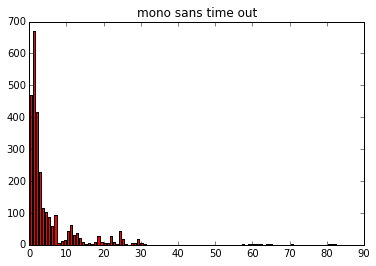

Il y a  20 problèmes qui dépassent la limite de  2000000 ms


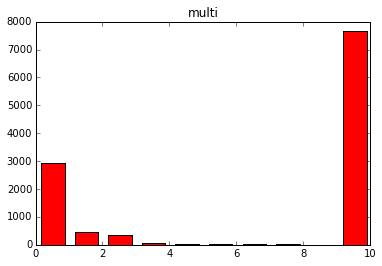

Il y a  0 problèmes qui dépassent la limite de  605000 ms


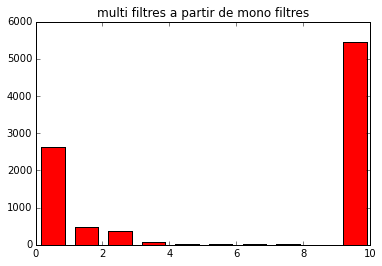

Il y a  0 problèmes qui dépassent la limite de  605000 ms


In [9]:
def makeHistoTotalTime(df, limite, bins=30, title=''):
    df = df['total time']
    s= pd.Series(df, name ='total time')
    tooL = [el for el in s if el > limite]
    a = pd.np.array(s)
    a = a/1000./60.   #convert into minutes
    
    hist, bins = np.histogram(a, bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.bar(center, hist, align='center', width=width,color = 'r')
    plt.title(title)
    plt.show()
    print 'Il y a ', len(tooL), 'problèmes qui dépassent la limite de ',limite,'ms'
    
makeHistoTotalTime(dfFin,2000000,bins = 100, title='mono sans time out')

makeHistoTotalTime(dfMulti,605000,bins = 10,title='multi')
makeHistoTotalTime(dfMulti_filt,605000,bins = 10,title='multi filtres a partir de mono filtres')

il y a  2415  pb à 8 agents
il y a  2415  pb à 8 agents qui time out
il y a  0  pb à 8 agents qui ne timent out pas


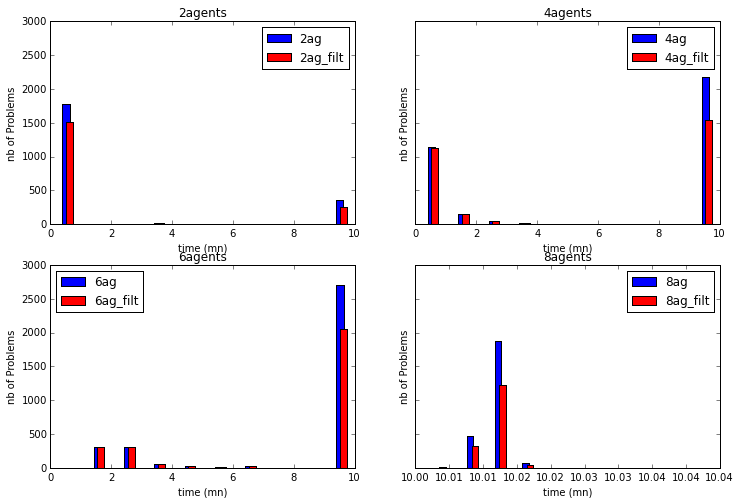

In [2]:
def one_agent(df, ax,align='center',label='', lAgents= [2], bins = 10,color = 'b', title= ''):
    df_xAg_l = [df[df['numagent'] == i] for i in lAgents]
    time_XAg_l = [xAg['total time'] for xAg in df_xAg_l]
    time_Series_XAg_l = [pd.np.array(pd.Series(df, name = 'total time')) for df in time_XAg_l]
    time_Series_XAg_l = [ts/1000./60.for ts in time_Series_XAg_l ]

    histbins_XAg_l = [np.histogram(a, bins = bins) for a in time_Series_XAg_l]
    width_XAg_l = [ 0.7 * (bins[1] - bins[0]) for hist,bins in histbins_XAg_l]
    center_XAg_l = [(bins[:-1] + bins[1:]) / 2 for hist,bins in histbins_XAg_l]
    color_Xag_l = ['r','b','y','g']
    p_XAg_l=[]
    for i in range (len(df_xAg_l)):
        hist, bins = histbins_XAg_l[i]
        p_XAg_l.append(ax.bar(center_XAg_l[i], hist,   width= width_XAg_l[i]/3, color=color, align = align))
  
    legends = ["".join([str(i),label])for i in lAgents]
    p_XAg_l = [p[0] for p in p_XAg_l]
    return p_XAg_l, legends 
        
def sub(ax, title, lAgents, bins= 10):    
    p_XAg_l, legends = one_agent(dfMulti,ax, 'center', 'ag', lAgents=lAgents, bins = bins,color = 'b')
    p_XAg_l2, legends2 = one_agent(dfMulti_filt,ax, 'edge', 'ag_filt', lAgents=lAgents, bins =bins, color = 'r')
    ax.legend( p_XAg_l+p_XAg_l2, legends+legends2 ,loc='best')
    ax.set_title(title)
    ax.set_xlabel('time (mn)')
    ax.set_ylabel('nb of Problems')
    
bins =10
fig, axes = plt.subplots(2,2,sharey=True, figsize=(12,8))

sub(axes[0,0], '2agents', [2], bins =bins)    
sub(axes[0,1], '4agents', [4], bins =bins)
sub(axes[1,0], '6agents', [6], bins =bins)
sub(axes[1,1], '8agents', [8], bins =bins)

#axes[1,1].set_xticks(range(0,11,2))
#axes[1,1].set_xticklabels(labels)
import matplotlib.ticker as ticker
axes[1,1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

df_8ag = dfMulti[dfMulti['numagent']==8]
print 'il y a ',len(df_8ag[['timed_out']]), ' pb à 8 agents'
print 'il y a ',len(df_8ag[df_8ag['timed_out']==1]), ' pb à 8 agents qui time out'
print 'il y a ',len(df_8ag[df_8ag['timed_out']==0]), ' pb à 8 agents qui ne timent out pas'



Time out à 10 minutes.

Ces courbes montrent que les problèmes qui sont difficiles en Mono agent sont aussi difficiles en multi-agents car la barre des problèmes filtrées est majoritairement affectée aux alentours de 10 mn indiquant un timeout dans le cas multi aussi.

Dans le cas du 2-agents, la différence entre les deux barres vers 1 mn montrent que la partition a permis de résoudre des problèmes mono qui ont time out en mono. On observe de même une légère différence pour 4 agents.

Le rapport d'amélioration des performances serait ici considérable  (de 10mn et plus, à moins d'1 mn) : il faut investiguer ces cas pour savoir s'il s'agit effectivement d'une amélioration ou alors si un problème plus profond se cache dessous.

On observe 

(ajouter les nouvelles données lundi au bureau pour voir les différences...
sur les premières courbes les 8 agents paraissent bizarres mais c'est parce qu'on n'apas fait tourner autant de problèmes)

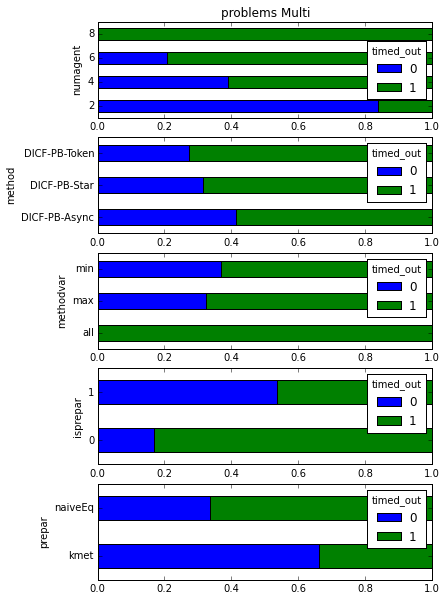

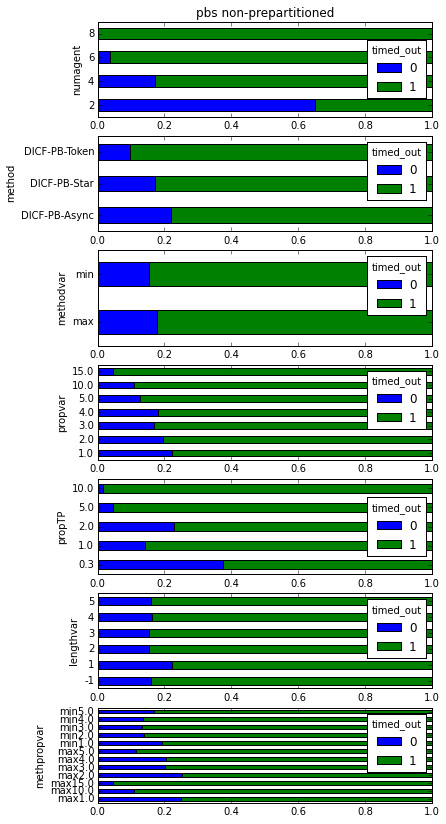

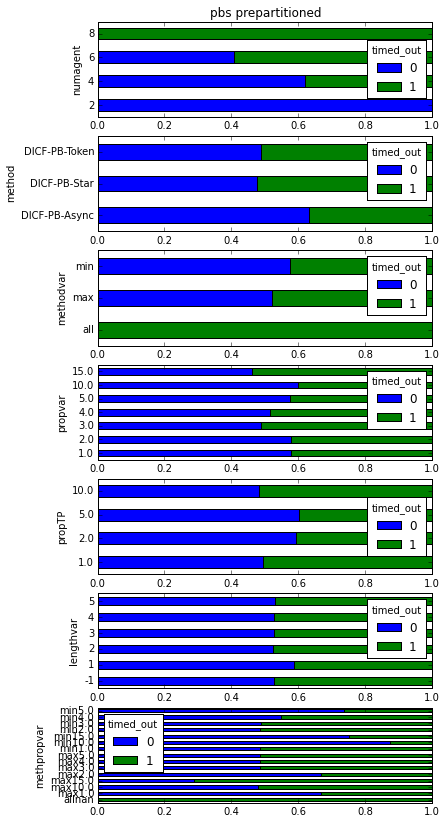

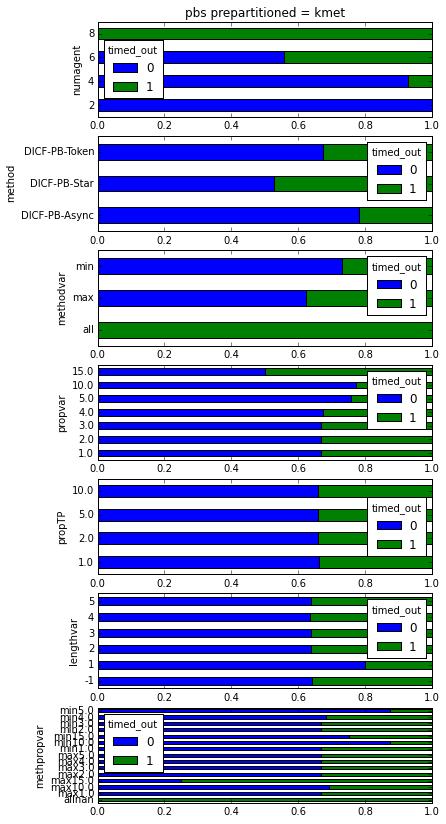

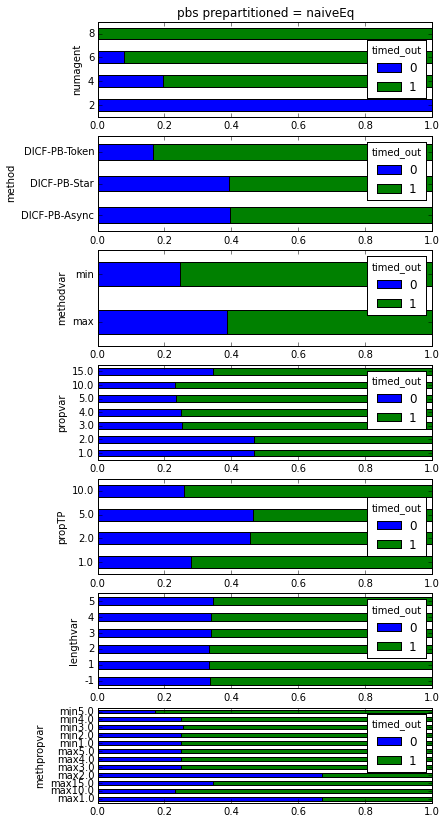

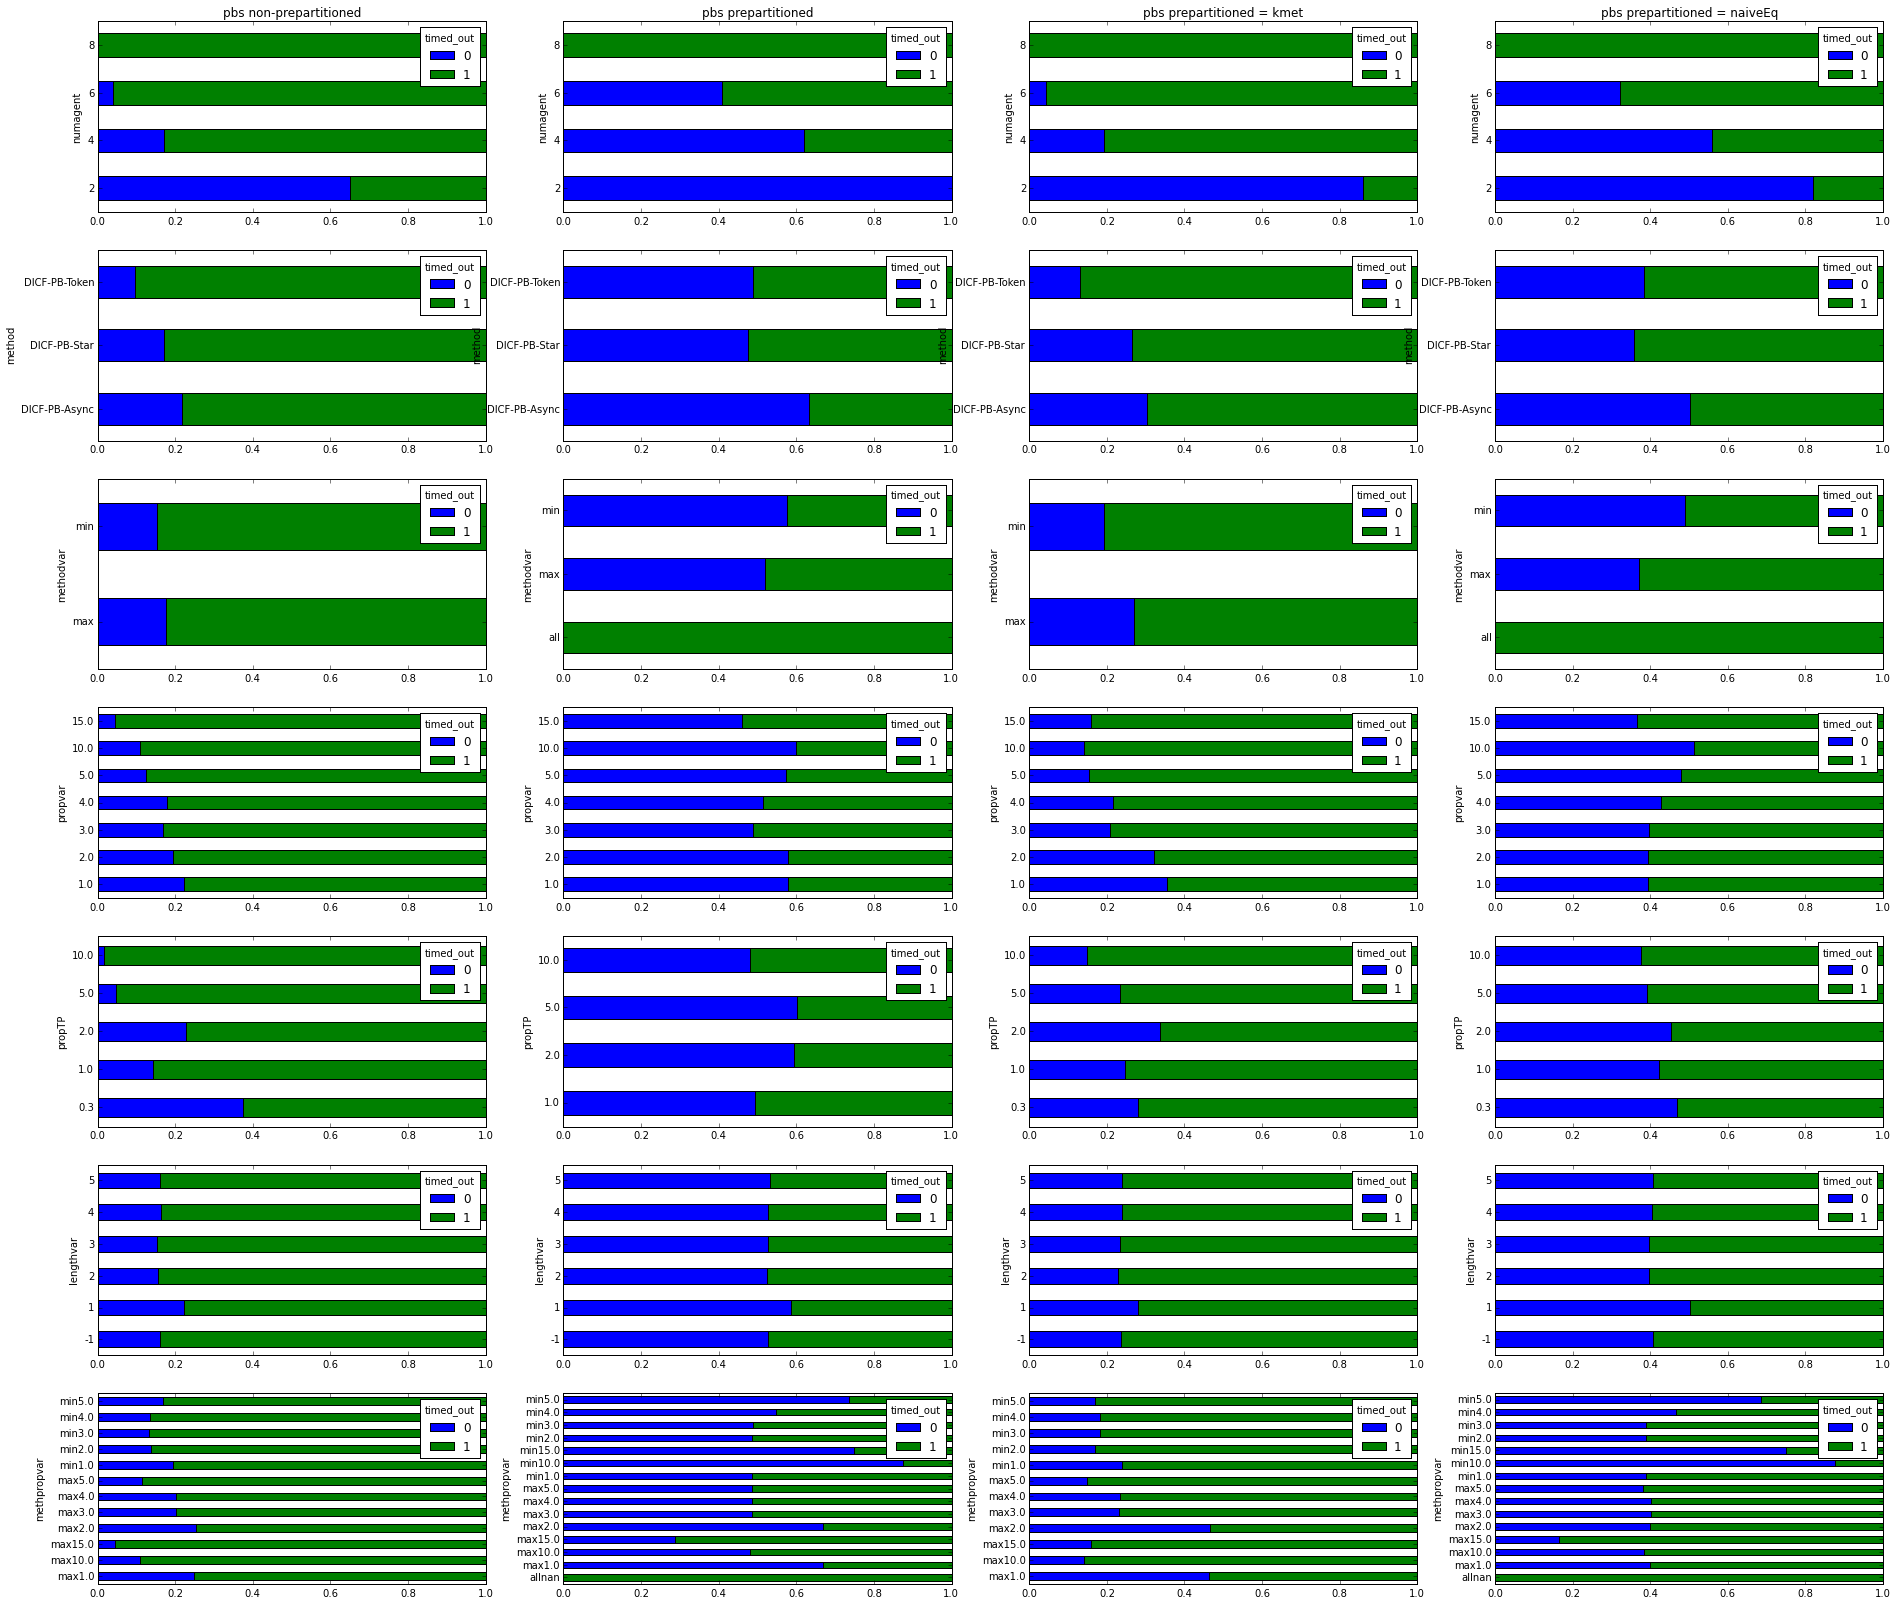

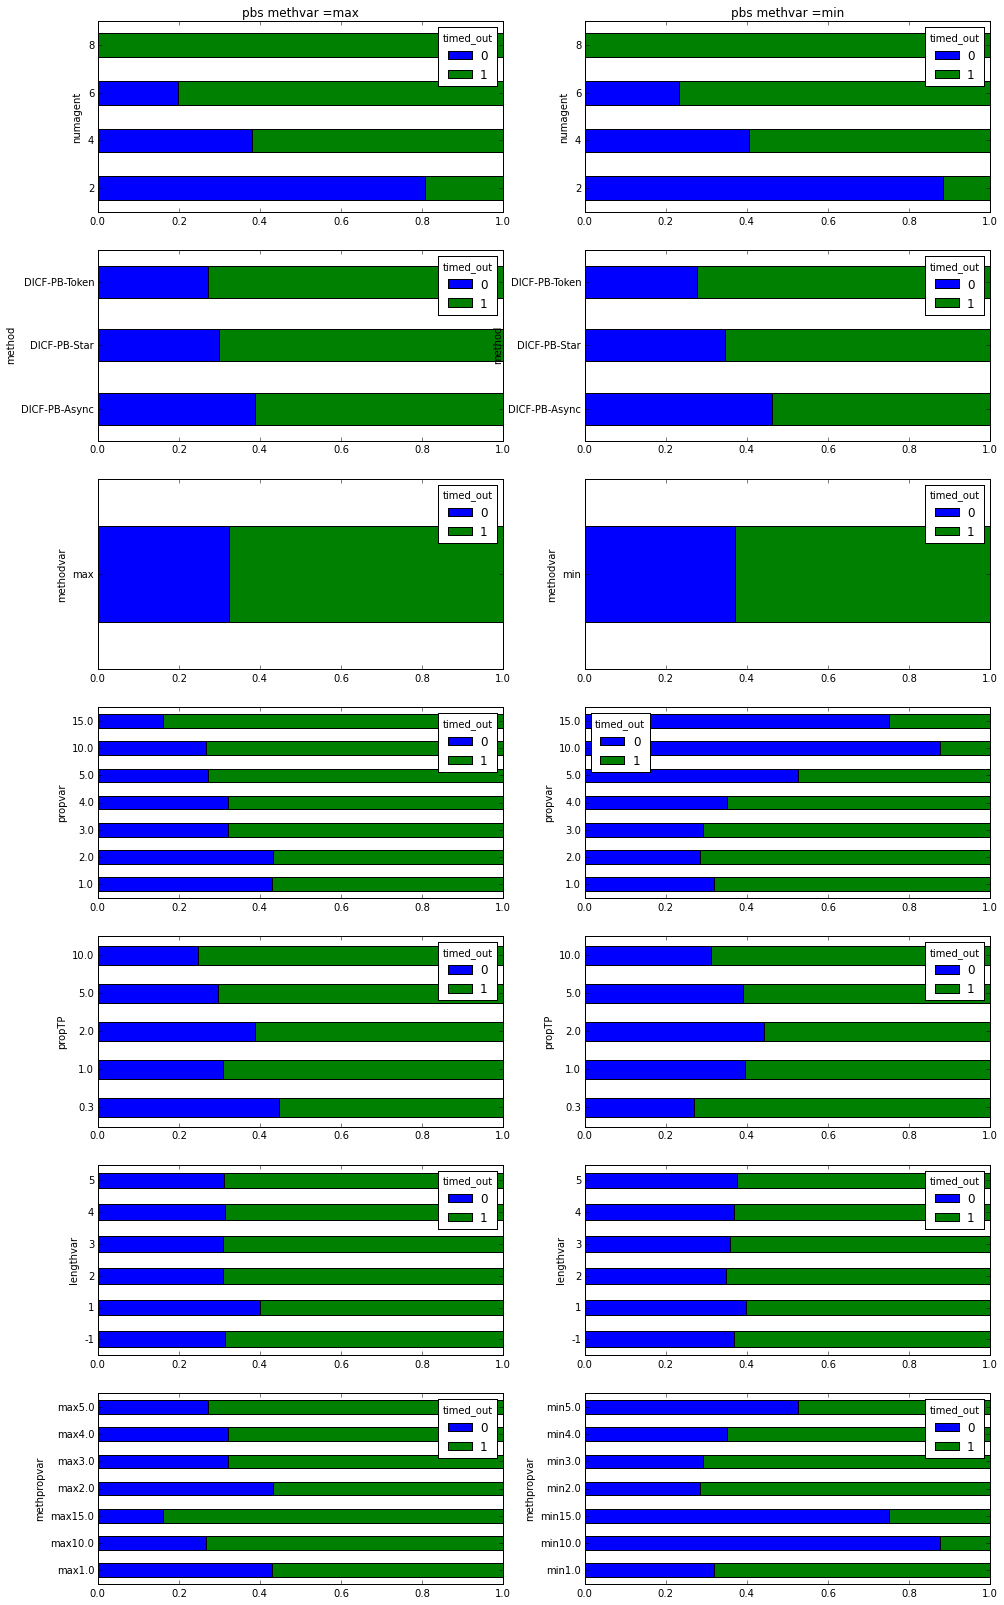

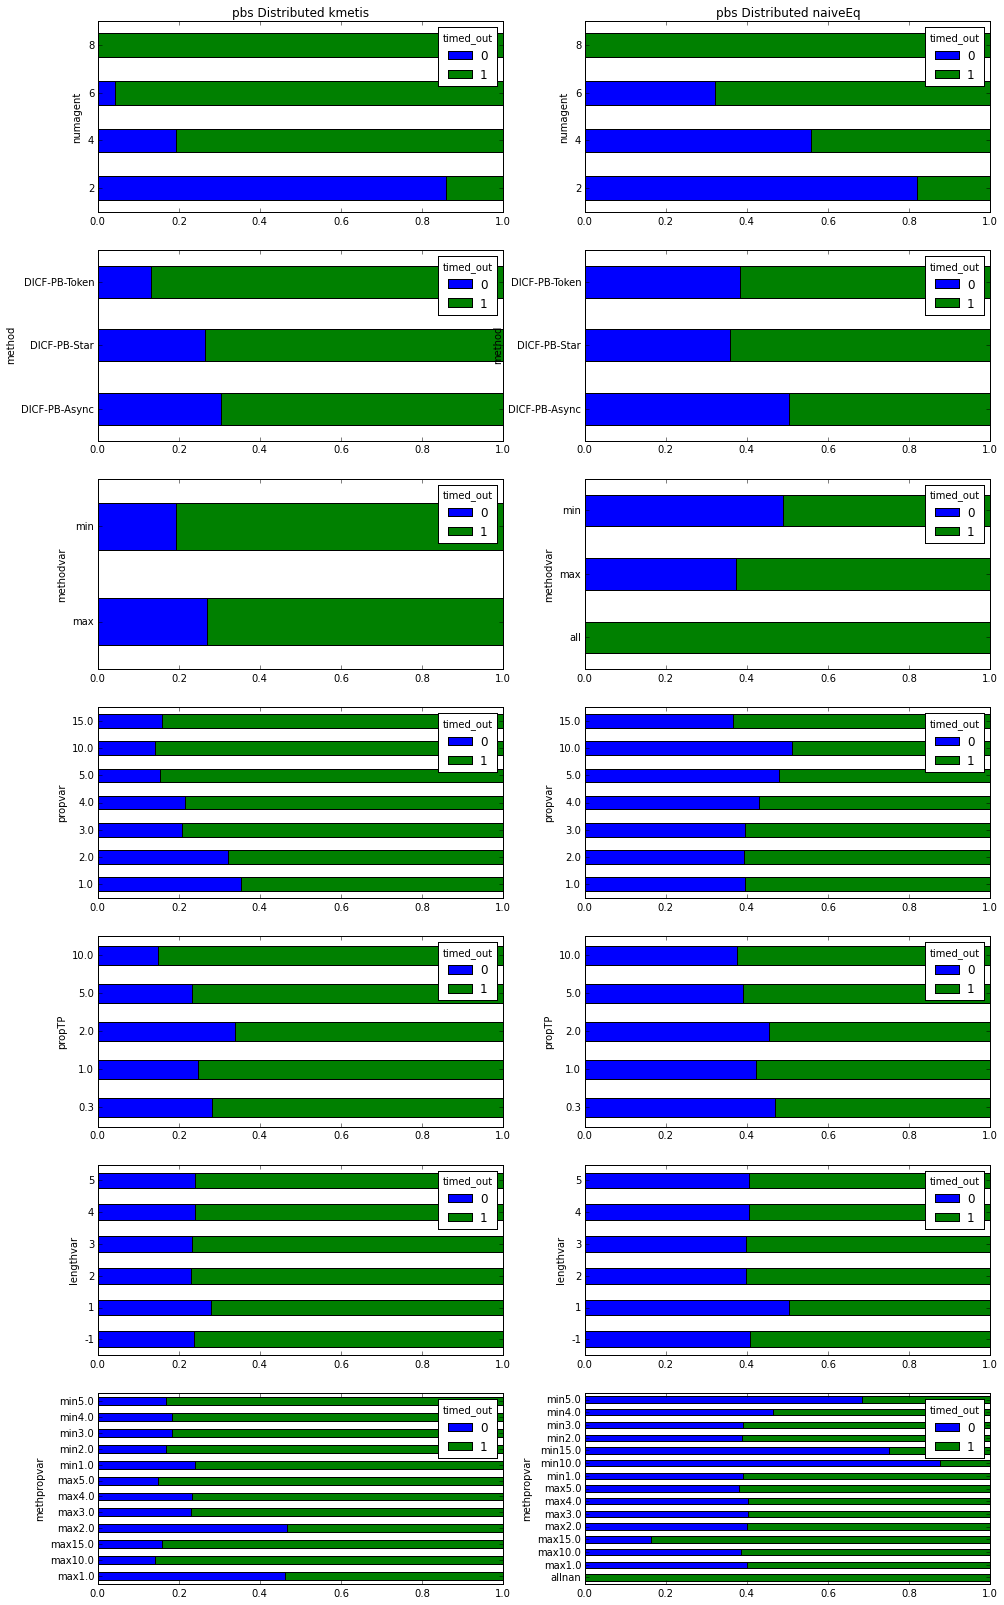

In [17]:
def proportionTimeOut(df,discreteVar):
    by_var = df.groupby([discreteVar,'timed_out']) #groups the data act on groups
       #seperately
    table = by_var.size() #gets group size counts, hashed by the two variables
    table = table.unstack() #splits the data into 2 columns, 0, 1, each indexed by the
    #other variable
    normedtable = table.div(table.sum(1), axis=0) #divides the counts by the totals
    return normedtable
def computeProp(df, discreteVarList=None, title=''):
    lenD = len(discreteVarList)
    fig1, axes1 = plt.subplots(lenD,1, figsize=(6,2 * lenD)) 
    for i in range(lenD):
        var = discreteVarList[i]
        table = proportionTimeOut(df,var)
        table.plot(kind='barh', stacked=True, ax=axes1[i])
    fig1.show()
    axes1[0].set_title(title)
    
computeProp(dfMulti, discreteVarList = ['numagent','method','methodvar','isprepar', 'prepar'], title = 'problems Multi')

df_nonprepar =  dfMulti[dfMulti['isprepar'] == 0]
df_prepar = dfMulti[dfMulti['isprepar']==1]
df_preparkmet = dfMulti[dfMulti['prepar'] == 'kmet']
df_preparnaiveEq = dfMulti[dfMulti['prepar'] == 'naiveEq']

df_max = dfMulti[dfMulti['methodvar'] == 'max']
df_min = dfMulti[dfMulti['methodvar'] == 'min']


df_kmet = dfMulti[dfMulti['dist'].str.contains('naiveEq')]
df_naiveEq = dfMulti[dfMulti['dist'].str.contains('kmet')]

discreteVarList = ['numagent','method','methodvar', 'propvar', 'propTP','lengthvar','methpropvar']

computeProp(df_nonprepar, discreteVarList = discreteVarList, title = 'pbs non-prepartitioned')
computeProp(df_prepar, discreteVarList =  discreteVarList, title = 'pbs prepartitioned')
computeProp(df_preparkmet, discreteVarList =  discreteVarList, title = 'pbs prepartitioned = kmet')
computeProp(df_preparnaiveEq, discreteVarList =  discreteVarList, title = 'pbs prepartitioned = naiveEq')



def computeProp_all(df,axes1, discreteVarList ='', title=''):
    lenD = len(discreteVarList)
    for i in range(lenD):
        var = discreteVarList[i]
        table = proportionTimeOut(df,var)
        table.plot(kind='barh', stacked=True, ax=axes1[i])
    axes1[0].set_title(title)
nbCol = 4
lenD = len(discreteVarList)
fig1, axes1 = plt.subplots(lenD,nbCol, figsize=(8*nbCol,4 * lenD)) 
computeProp_all(df_nonprepar, axes1[:,0],discreteVarList = discreteVarList, title = 'pbs non-prepartitioned')
computeProp_all(df_prepar, axes1[:,1],discreteVarList = discreteVarList, title = 'pbs prepartitioned')
computeProp_all(df_kmet, axes1[:,2],discreteVarList = discreteVarList, title = 'pbs prepartitioned = kmet')
computeProp_all(df_naiveEq, axes1[:,3],discreteVarList = discreteVarList, title = 'pbs prepartitioned = naiveEq')
plt.savefig('table_all_partitions.png')



nbCol = 2
lenD = len(discreteVarList)
fig1, axes1 = plt.subplots(lenD,nbCol, figsize=(8*nbCol,4 * lenD)) 
computeProp_all(df_max, axes1[:,0],discreteVarList = discreteVarList, title = 'pbs methvar =max')
computeProp_all(df_min, axes1[:,1],discreteVarList = discreteVarList, title = 'pbs methvar =min')


nbCol = 2
lenD = len(discreteVarList)
fig1, axes1 = plt.subplots(lenD,nbCol, figsize=(8*nbCol,4 * lenD)) 
computeProp_all(df_kmet, axes1[:,0],discreteVarList = discreteVarList, title = 'pbs Distributed kmetis')
computeProp_all(df_naiveEq, axes1[:,1],discreteVarList = discreteVarList, title = 'pbs Distributed naiveEq')


In [57]:
#what we are trying to do is a graphical pivot table !! 
# here we want to be able to plot things more complex, for instance for a Dataframe,
#for different methvar, the different proportions, and we want the graphs to be side by side
#here for level 2
#if we do more levels, then 

#for timeout
#one level : methvar, create one subplot, graph only
#two levels : [methvar, propvar] -> create one subplot, and a column for each methvar, do a selection on column propvar
#three levels : [distmeth,methvar,propvar] -> create one subplot for each disthmeth

#attention à ce que l'avant dernier niveau ne soit pas trop grand... car sera en colonnes...
def proportionTimeOut(df,discreteVar):
    by_var = df.groupby([discreteVar,'timed_out']) #groups the data act on groups
       #seperately
    table = by_var.size() #gets group size counts, hashed by the two variables
    table = table.unstack() #splits the data into 2 columns, 0, 1, each indexed by the
    #other variable
    normedtable = table.div(table.sum(1), axis=0) #divides the counts by the totals
    return normedtable
def drawOneGraph():
    pass
def drawOneGraphWithColumns(df,el,l,title):
    discreteVarList = df[l].unique()
    lenD = len(discreteVarList)
    
    fig1, axes = plt.subplots(1,lenD, figsize=(4 * lenD,6))
    fig1.suptitle(title)
    print axes
    print tail
    for i in range(lenD):
        var = discreteVarList[i]
        df_var = df[df[l]==var]
        
        table = proportionTimeOut(df_var, el)
        try:
            table.plot(kind='barh', stacked=True, ax=axes[i])
        except:
            print 'exception caught'
        axes[i].set_title(l+ ':' + str(var))
    fig1.show()
def computeStatsLevels(df,el,l=None):
    if len(l) ==0 :
        drawOneGraph()
        print 'not implemented easy shit'
    elif len(l) ==1 :
        drawOneGraphWithColumns(df,el,l,'')
    else:#max == 3 pour lisibilité, et explosion combinatoire... -> bruit
        head, tail = l[0], l[1:]
        print l
        print head, tail
        #get unique values for head dimension and recurse with tail
        discreteVarList = df[head].unique()
        lenD = len(discreteVarList)
        for i in range(lenD):
            var = discreteVarList[i]
            df_var = df[df[head]==var]
            title = head +': '+ str(var)
            
            drawOneGraphWithColumns(df_var, el,tail,title)
        
computeStatsLevels(dfMulti,'propvar', l = ['distmethod','methodvar'])


#computeStatsLevels(dfMulti, l = ['distmethod','methodvar', 'propvar'])

['distmethod', 'methodvar']
distmethod ['methodvar']


AttributeError: 'DataFrame' object has no attribute 'unique'

0    (23.5, 43]
1    (23.5, 43]
2    (23.5, 43]
3    (62.5, 82]
4    (43, 62.5]
Name: nb Messages disc, dtype: category
Categories (10, object): [(3.805, 23.5] < (23.5, 43] < (43, 62.5] < (62.5, 82] ... (121, 140.5] < (140.5, 160] < (160, 179.5] < (179.5, 199]]


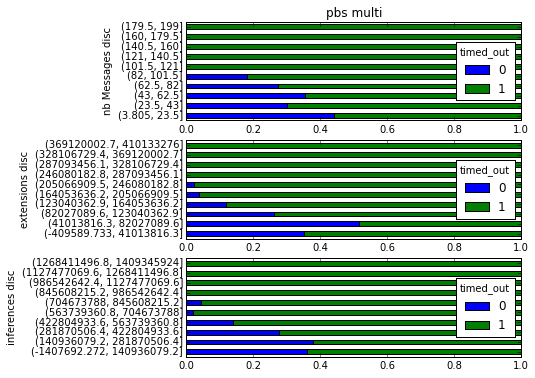

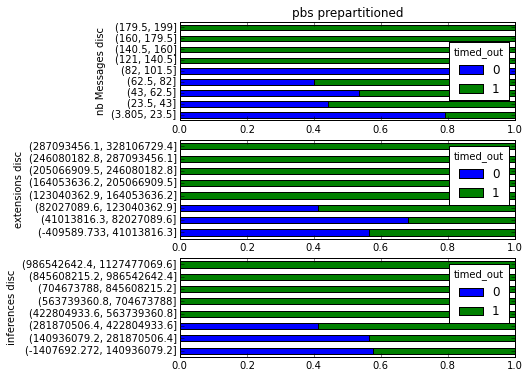

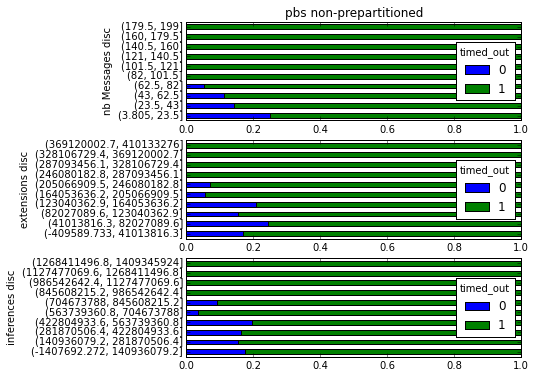

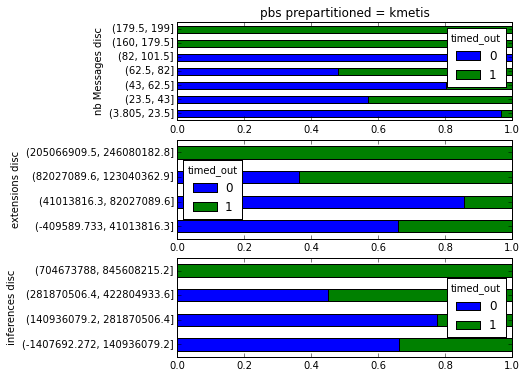

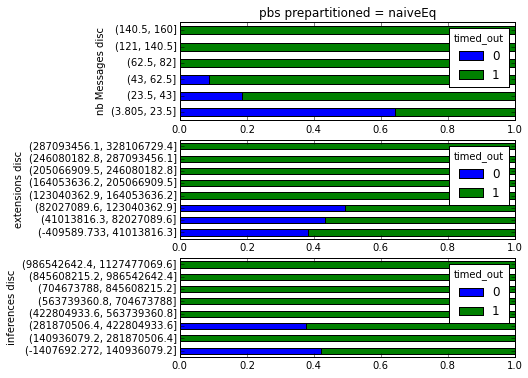

In [4]:
bins =10
def makeNewCol(dfMulti):
    dfMulti['nb Messages disc'] =dfMulti['nb Messages'] 
    dfMulti['nb Messages disc'] = pd.cut(dfMulti['nb Messages disc'],bins)

    dfMulti['extensions disc'] =dfMulti['extensions'] 
    dfMulti['extensions disc'] = pd.cut(dfMulti['extensions disc'],bins)


    dfMulti['inferences disc'] =dfMulti['inferences'] 
    dfMulti['inferences disc'] = pd.cut(dfMulti['inferences disc'],bins)
    print dfMulti['nb Messages disc'].head()
discreteVarList = ['nb Messages disc','extensions disc','inferences disc' ]
makeNewCol(dfMulti)

df_nonprepar =  dfMulti[dfMulti['isprepar'] == 0]
df_prepar = dfMulti[dfMulti['isprepar']==1]
df_kmet = dfMulti[dfMulti['prepar'] == 'kmet']
df_naiveEq = dfMulti[dfMulti['prepar'] == 'naiveEq']

#makeNewCol(df_prepar)
#makeNewCol(df_nonprepar)
#makeNewCol(df_kmet)
#makeNewCol(df_naiveEq)
computeProp(dfMulti, discreteVarList = discreteVarList, title = 'pbs multi')
computeProp(df_prepar, discreteVarList = discreteVarList, title = 'pbs prepartitioned')
computeProp(df_nonprepar, discreteVarList = discreteVarList, title = 'pbs non-prepartitioned')
computeProp(df_kmet, discreteVarList = discreteVarList, title = 'pbs prepartitioned = kmetis')

computeProp(df_naiveEq, discreteVarList = discreteVarList, title = 'pbs prepartitioned = naiveEq')
#computeProp(dfMulti, discreteVarList =  discreteVarList, title = 'pbs prepartitioned')


ces courbes ne sont pas très intéressantes et très parlantes, on pourrait trouver une meilleure visualisation.

In [11]:

dfMulti.pivot_table('timed_out', index = ['distmethod', 'propvar'], columns = ['methodvar'],aggfunc='mean')

methodvar                max       min
distmethod propvar                    
kmet       1        0.600000  0.610603
           2        0.600000  0.611511
           3        0.597846  0.610687
           4        0.597846  0.534314
           5        0.618705  0.315589
           10       0.615385  0.125000
           15       0.835616  0.250000
naiveEq    1        0.537255  0.759754
           2        0.533333  0.830303
           3        0.768612  0.816810
           4        0.766600  0.817518
           5        0.850505  0.830508
           10       0.858824       NaN
           15       0.840532       NaN

In [14]:
discreteVarList = ['numagent','method','methodvar', 'propvar', 'propTP','lengthvar','methpropvar']
dfMulti.pivot_table('timed_out', index = ['distmethod', 'isprepar','propvar'], columns = ['methodvar'],aggfunc='mean')

methodvar                         max       min
distmethod isprepar propvar                    
kmet       0        1        0.821782  0.847458
                    2        0.821782  0.842105
                    3        0.816393  0.867647
                    4        0.816393  0.864198
                    5        0.855263  0.830986
                    10       0.861386       NaN
                    15       0.930636       NaN
           1        1        0.333333  0.333333
                    2        0.333333  0.333333
                    3        0.333333  0.333333
                    4        0.333333  0.317073
                    5        0.333333  0.125000
                    10       0.308642  0.125000
                    15       0.750000  0.250000
naiveEq    0        1        0.679868  0.766102
                    2        0.673267  0.881188
                    3        0.780328  0.867647
                    4        0.777049  0.864198
                    5        0.914191  0.830986
                    10       0.920792       NaN
                    15       0.976879       NaN
           1        1        0.328502  0.750000
                    2        0.328502  0.750000
                    3        0.750000  0.744792
                    4        0.750000  0.750000
                    5        0.750000  0.829787
                    10       0.768116       NaN
                    15       0.656250       NaN

In [14]:
discreteVarList = ['numagent','method','methodvar', 'propvar', 'propTP','lengthvar','methpropvar']
dfMulti.pivot_table(['timed_out','nb Messages', 'inferences'], index = ['distmethod', 'isprepar','propvar'], columns = ['methodvar'],aggfunc='mean')

timed_out           nb Messages             \
methodvar                         max       min         max        min   
distmethod isprepar propvar                                              
kmet       0        1        0.821782  0.847458   41.435644  39.684746   
                    2        0.821782  0.842105   42.392739  39.151316   
                    3        0.816393  0.867647   42.422951  39.647059   
                    4        0.816393  0.864198   43.449180  38.154321   
                    5        0.855263  0.830986   43.065789  37.676056   
                    10       0.861386       NaN   44.930693        NaN   
                    15       0.930636       NaN   41.514451        NaN   
           1        1        0.333333  0.333333   50.539683  50.055556   
                    2        0.333333  0.333333   51.916667  49.436508   
                    3        0.333333  0.333333   53.138889  49.686508   
                    4        0.333333  0.317073   54.404762  48.532520   
                    5        0.333333  0.125000   53.916667  34.531250   
                    10       0.308642  0.125000   55.123457  34.791667   
                    15       0.750000  0.250000   36.057292  33.338542   
naiveEq    0        1        0.679868  0.766102   35.808581  35.281356   
                    2        0.673267  0.881188   36.867987  34.425743   
                    3        0.780328  0.867647   35.537705  34.897059   
                    4        0.777049  0.864198   36.754098  29.623457   
                    5        0.914191  0.830986   37.062706  29.169014   
                    10       0.920792       NaN   36.369637        NaN   
                    15       0.976879       NaN   29.705202        NaN   
           1        1        0.328502  0.750000   36.323671  32.250000   
                    2        0.328502  0.750000   36.888889  31.880208   
                    3        0.750000  0.744792   33.848958  31.369792   
                    4        0.750000  0.750000   34.984375  32.580357   
                    5        0.750000  0.829787   33.552083  42.936170   
                    10       0.768116       NaN   35.454106        NaN   
                    15       0.656250       NaN   32.929688        NaN   

                               inferences                
methodvar                             max           min  
distmethod isprepar propvar                              
kmet       0        1        5.533635e+07  9.446900e+07  
                    2        5.014557e+07  8.725000e+07  
                    3        5.039792e+07  1.019345e+08  
                    4        4.840411e+07  1.186789e+08  
                    5        3.145484e+07  1.256062e+08  
                    10       6.911877e+07           NaN  
                    15       1.087745e+08           NaN  
           1        1        4.541037e+07  4.515449e+07  
                    2        4.501534e+07  4.549419e+07  
                    3        4.474004e+07  4.486049e+07  
                    4        5.399434e+07  4.728386e+07  
                    5        7.410060e+07  4.644102e+07  
                    10       7.528321e+07  4.643780e+07  
                    15       2.241778e+08  2.908128e+07  
naiveEq    0        1        1.060899e+08  1.060119e+08  
                    2        1.073075e+08  1.051506e+08  
                    3        1.189710e+08  9.706109e+07  
                    4        1.152695e+08  3.339659e+07  
                    5        9.339145e+07  8.407923e+07  
                    10       1.253800e+08           NaN  
                    15       8.866776e+07           NaN  
           1        1        1.268084e+08  2.147649e+08  
                    2        1.260109e+08  1.068949e+08  
                    3        2.566325e+08  4.991738e+07  
                    4        2.564254e+08  7.601960e+07  
                    5        6.870647e+07  6.816622e+07  
                    10       1.007767e+08          

In [16]:
discreteVarList = ['numagent','method','methodvar', 'propvar', 'propTP','lengthvar','methpropvar']
dfMulti.pivot_table(['timed_out','nb Messages', 'inferences'], index = ['distmethod', 'isprepar'], columns = ['numagent'],aggfunc='mean')

timed_out                        nb Messages             \
numagent                    2         4         6  8           2          4   
distmethod isprepar                                                           
kmet       0         0.418146  0.848850  0.948387  1    6.187377  27.284775   
           1         0.000000  0.071429  0.444444  1    7.660714  36.571429   
naiveEq    0         0.283168  0.809419  0.974194  1    6.316832  19.486309   
           1         0.000000  0.803523  0.920833  1    6.683594  23.112466   

                                                 inferences                \
numagent                     6           8                2             4   
distmethod isprepar                                                         
kmet       0         49.507527   72.850667  19050716.824458  2.971182e+07   
           1         52.050000  103.102564      4720.428571  2.300068e+07   
naiveEq    0         34.566667   74.042667  24991075.885149  7.078942e+07   
           1         43.810417   87.460606     11839.933594  1.793875e+08   

                                                 
numagent                        6             8  
distmethod isprepar                              
kmet       0         1.166797e+08  1.018449e+08  
           1         1.233055e+08  6.996854e+07  
naiveEq    0         1.391596e+08  1.493000e+08  
           1         1.503428e+08  2.148395e+08

il faudrait confirmer ces intuitions sur des problèmes avec plus de faits etc...

#cas intéressants
on veut s'intéresser aux problèmes multi qui finissent plus tôt que leur poblèmes mono



ici c'Est les pb prépartitionné qui nous occupent

5405
6198
1999
5405
6198
310


/home/magma/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


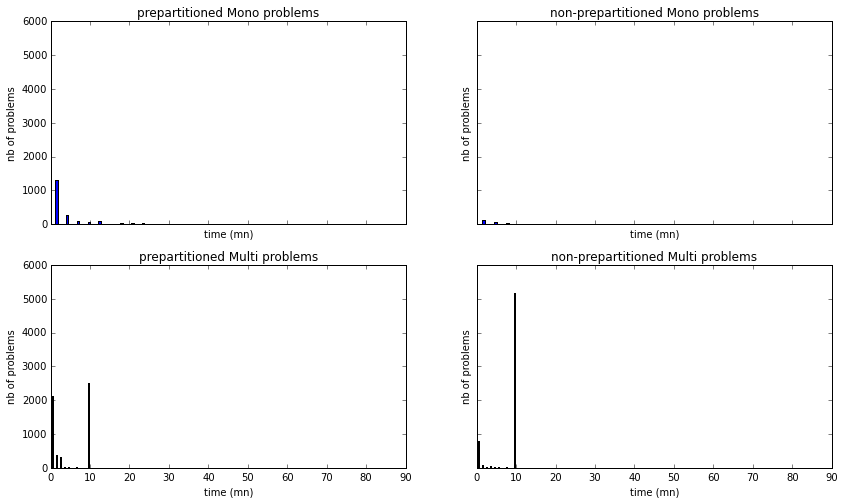

In [6]:
def sub_func(df_xAg_l,ax, title,bins= 10):
    color= 'b'
    align='center'
    ax.set_xlabel('time (mn)')
    ax.set_ylabel('nb of problems')
    ax.set_title(title)
    time_XAg_l = [xAg['total time'] for xAg in df_xAg_l]
    time_Series_XAg_l = [pd.np.array(pd.Series(df, name = 'total time')) for df in time_XAg_l]
    time_Series_XAg_l = [ts/1000./60.for ts in time_Series_XAg_l ]

    histbins_XAg_l = [np.histogram(a, bins = bins) for a in time_Series_XAg_l]
    width_XAg_l = [ 0.7 * (bins[1] - bins[0]) for hist,bins in histbins_XAg_l]
    center_XAg_l = [(bins[:-1] + bins[1:]) / 2 for hist,bins in histbins_XAg_l]
    color_Xag_l = ['r','b','y','g']
    p_XAg_l=[]
    for i in range (len(df_xAg_l)):
        hist, bins = histbins_XAg_l[i]
        p_XAg_l.append(ax.bar(center_XAg_l[i], hist,   width= width_XAg_l[i]/3, color=color, align = align))



df = dfMulti
df_prepar = df[df['isprepar']==1]
df_nonprepar = df[~(df['isprepar']==1)]#attention ici il FAUT mettre les parenthèses...

print len(df_prepar)
print len(df_nonprepar)

aggregate(df_prepar)#agg est une sorte d'id de problem
aggregate(dfFin)
df_mono = dfFin[dfFin['indagg'].isin(df_prepar['indagg'])]

print len(df_mono)

df_xAg_l= [df_mono]
fig, axes = plt.subplots(2,2,sharey=True, sharex= True, figsize=(14,8))
ax= axes[0,0]
sub_func( df_xAg_l,ax,'prepartitioned Mono problems',bins = 30)

df_xAg_l= [df_prepar]
ax= axes[1,0]
sub_func( df_xAg_l,ax,'prepartitioned Multi problems',bins = 10)



aggregate(dfMulti)#agg est une sorte d'id de problem
aggregate(dfFin)

df = dfMulti
df_prepar = df[df['isprepar']==1]
df_nonprepar = df[~(df['isprepar']==1)]#attention ici il FAUT mettre les parenthèses...
print len(df_prepar)
print len(df_nonprepar)
df_mono = dfFin[dfFin['indagg'].isin(df_nonprepar['indagg'])]
print len(df_mono)

df_xAg_l= [df_mono]
ax= axes[0,1]
sub_func( df_xAg_l,ax,'non-prepartitioned Mono problems',bins=10)

df_xAg_l= [df_nonprepar]
ax= axes[1,1]
sub_func( df_xAg_l,ax,'non-prepartitioned Multi problems',bins=10)


Ce que l'on peut en déduire, c'est que la manière dont on génère nos problèmes pré-partitionnés les rend plus facile même en mono (on vérifie cela à la section suivante = que les problèmes mono prépar sont plus faciles que leurs équivalents non prépar) et que comme on a généré beaucoup de problèmes faciles en mono, cela se voit sur les problèmes multi.

Il s'agit maintenant de voir les problèmes qui sont résolus plus rapidement en multi qu'en mono

Ici on regarde donc la différence entre les problèmes mono prépartitionnés et les problèmes mono non_prépartitionnés pour voir s'il y a une réelle amélioration.

On prend donc un problème tq : propTP, var et baseinfile soient les mêmes et on regarde leur temps d'exécution.
Cela pour différents problèmes.


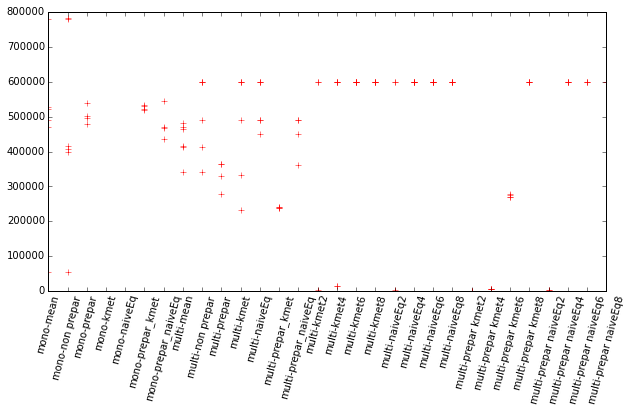

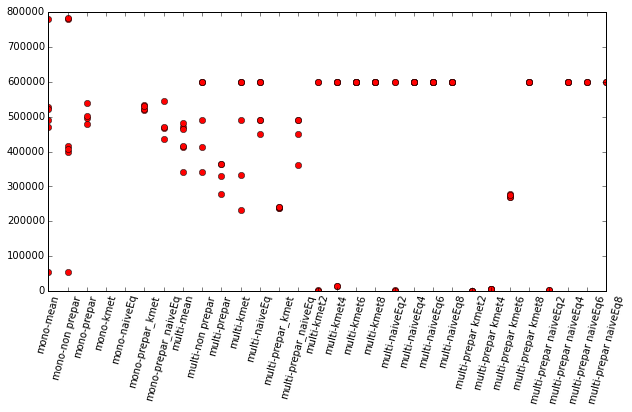

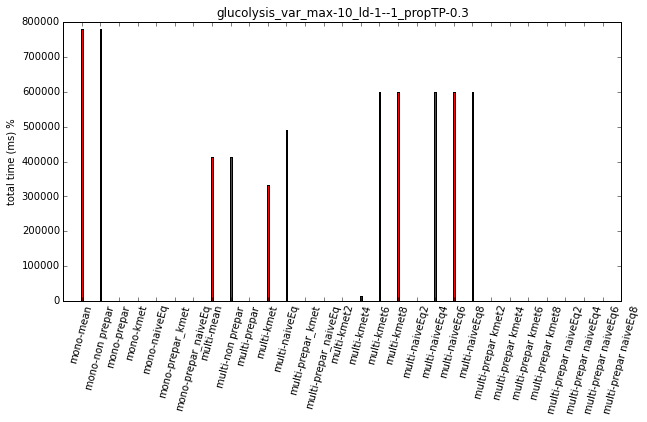

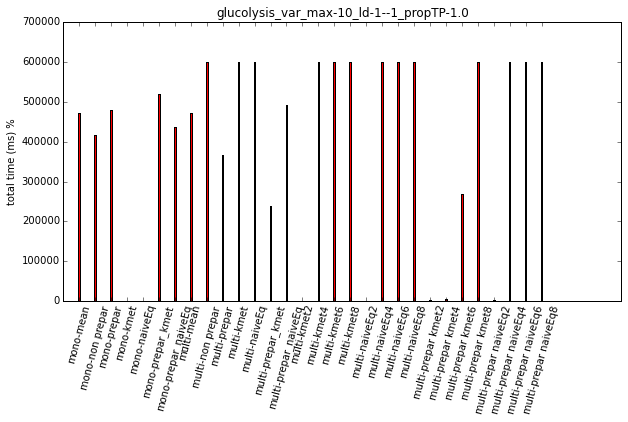

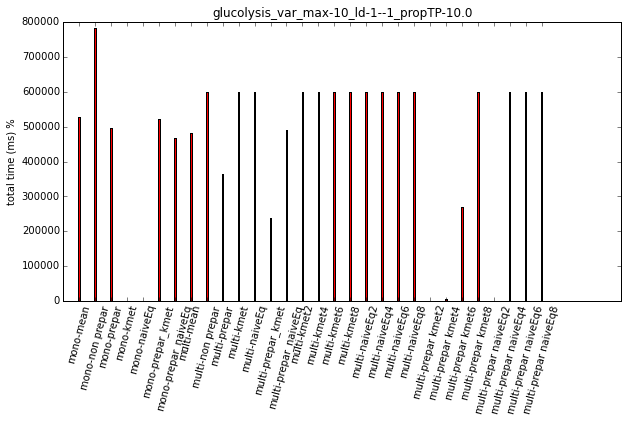

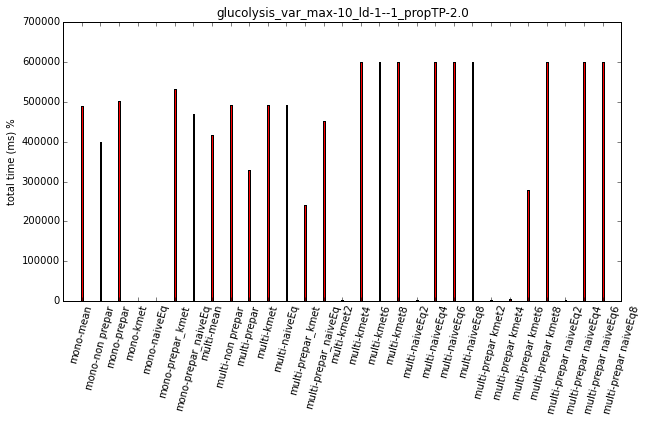

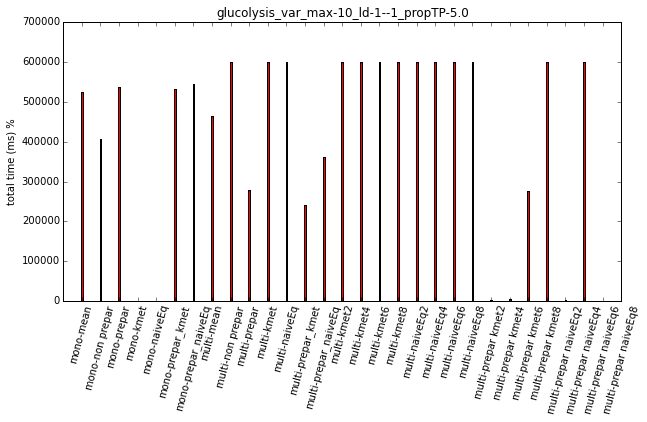

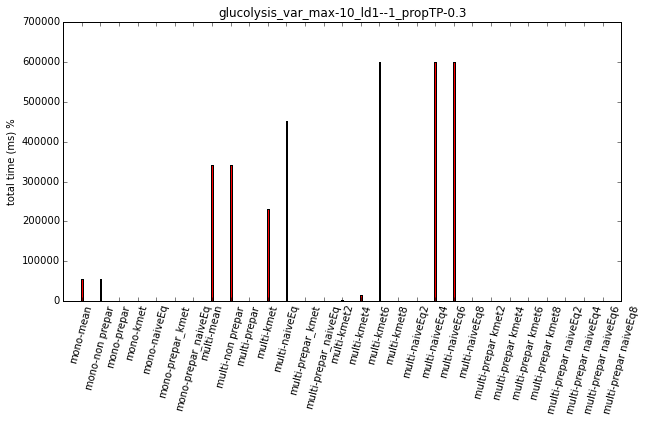

In [22]:
def computeHist(df,ismulti=False):
    hist = []
    #recupere les problems non part
    pb_nonpar = df[df['isprepar']==0]
    pb_par = df[df['isprepar']==1]
    pb_prepar_naiveEq = df[df['prepar']=='naiveEq']
    pb_prepar_kmet = df[df['prepar']=='kmet']

    pb_nonprepar_naiveEq = df[(df['dist'].str.contains('naiveEq'))&(df['isprepar']==0)]
    pb_nonprepar_kmet = df[(df['dist'].str.contains('kmet'))&(df['isprepar']==0)]



    hist.append(df[var].mean())
    hist.append(pb_nonpar[var].mean())
    hist.append(pb_par[var].mean())

    hist.append(pb_nonprepar_kmet[var].mean())
    hist.append(pb_nonprepar_naiveEq[var].mean())

    hist.append(pb_prepar_kmet[var].mean())
    hist.append(pb_prepar_naiveEq[var].mean())

    if ismulti:
        par = ['kmet','naiveEq']
        ag = [2,4,6,8]
        for pb_kmet, pb_naiveEq in [(pb_nonprepar_kmet,pb_nonprepar_naiveEq),(pb_prepar_kmet,pb_prepar_naiveEq)]:
            for p in par:
                for a in ag:
                    if p == 'kmet':
                        pb_local = pb_kmet[pb_kmet['numagent']==a]
                    else:
                        pb_local = pb_naiveEq[pb_naiveEq['numagent']==a]
                    hist.append(pb_local[var].mean())
    return hist

import math
def aggregate_mono(df):
    df['indagg_mono'] =  df['pbbase'] + '_var'+df['var'].map(str) + '_propTP-'+df['propTP'].map(str) # +df['dist']



#plotter le tps d'Exec des problems non-prépartitionnés 
#en fonction de propvar, lengthvar, propTP

#et plotter la même chose pour les différentes prépartitions et les différents agents.

#l'idéal étant d'avoir sur une même courbe la référence et les deux variantesdonc d'Avoir 
#4 = [2,4,6,8 agents]
#et 3 dimensions à explorer soit 12 graphiques au total
def makeHistoTotalTime(df, limite, bins=30, title=''):
    df = df['total time']
    s= pd.Series(df, name ='total time')
    tooL = [el for el in s if el > limite]
    a = pd.np.array(s)
    a = a/1000./60.   #convert into minutes
    
    hist, bins = np.histogram(a, bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    
    
    plt.bar(center, hist, align='center', width=width,color = 'r')
    plt.title(title)
    plt.show()
    print 'Il y a ', len(tooL), 'problèmes qui dépassent la limite de ',limite,'ms'
    

#centers = mono, kmet, naiveEq, kmet
#r = dfFin.groupby([['propTP','propvar','lengthvar','dist','prepar', 'methodvar']])

figcum, axcum = plt.subplots(figsize = (10,5))

figcumbis, axcumbis = plt.subplots(figsize = (10,5))
centers = [1,2,3,4,5]#,6,7,8]
aggregate_mono(dfFin)
aggregate_mono(dfMulti)
#aggregate_mono
i = 0
var = 'total time'
width = 0.1
for names, group in dfMulti.groupby(['indagg_mono']):
    #(propTP, propvar, lengthvar, dist, prepar,methodvar) = names
    if len(group.index) > 10:
        labels = ['mean','non prepar','prepar','kmet', 'naiveEq', 'prepar_kmet','prepar_naiveEq']
        labelsMulti = ['kmet2','kmet4', 'kmet6', 'kmet8', 'naiveEq2','naiveEq4', 'naiveEq6', 'naiveEq8',\
                  'prepar kmet2','prepar kmet4', 'prepar kmet6', 'prepar kmet8', 'prepar naiveEq2','prepar naiveEq4', 'prepar naiveEq6', 'prepar naiveEq8']
        hist= []
        
        
        
    
            #print hist
        #mono
        monopb = dfFin[dfFin['indagg_mono'] == names]
        
        hist +=computeHist(monopb)
        new_labels = ['mono-'+label for label in labels]
        #multi
        #group
       
        hist +=computeHist(group,ismulti = True)
        new_labels += ['multi-'+label for label in labels]
        new_labels += ['multi-'+label for label in labelsMulti]
        labels = new_labels
        """
        if len(hist) < len(labels):
            continue
        mustcontinue= False
        for el in hist:
            if math.isnan(el):
                mustcontinue= True
                break
        if mustcontinue :
            continue
        """
        fig, ax = plt.subplots(figsize = (10,5))
        ax.set_ylabel('total time (ms) %')
        ax.set_title(names)
        centers = range(1,len(hist)+1)
        ax.bar(centers, hist, align='center', width=width,color = 'r')
        ax.set_xticks(centers)#,rot='vertical')
        ax.set_xticklabels(labels[:len(hist)],rotation=75)

        axcum.plot(centers, hist, '+', color = 'r')
        axcum.set_xticks(centers)
        axcum.set_xticklabels(labels[:len(hist)],rotation=75)
        
        axcumbis.plot(centers, hist, 'ro', color = 'r')
        axcumbis.set_xticks(centers)#,rot='vertical')
        axcumbis.set_xticklabels(labels[:len(hist)],rotation=75)
        i+=1
        if i >5:
            break

#by_var['nb Messages'].agg(['mean']).plot(ax=ax,kind = 'bar',width = 0.2,position =0)

['mono-mean', 'mono-non prepar', 'mono-prepar', 'mono-kmet', 'mono-naiveEq', 'mono-prepar_kmet', 'mono-prepar_naiveEq', 'multi-mean', 'multi-non prepar', 'multi-prepar', 'multi-kmet', 'multi-naiveEq', 'multi-prepar_kmet', 'multi-prepar_naiveEq', 'multi-kmet2', 'multi-kmet4', 'multi-kmet6', 'multi-kmet8', 'multi-naiveEq2', 'multi-naiveEq4', 'multi-naiveEq6', 'multi-naiveEq8', 'multi-prepar kmet2', 'multi-prepar kmet4', 'multi-prepar kmet6', 'multi-prepar kmet8', 'multi-prepar naiveEq2', 'multi-prepar naiveEq4', 'multi-prepar naiveEq6', 'multi-prepar naiveEq8']
['mono-mean', 'multi-mean', 'mono-non prepar', 'multi-non prepar', 'mono-prepar', 'multi-prepar', 'mono-prepar_kmet', 'multi-prepar_kmet', 'mono-prepar_naiveEq', 'multi-prepar_naiveEq']
[0, 7, 1, 8, 2, 9, 5, 12, 6, 13, 10, 11, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
['mono-mean', 'mono-non prepar', 'mono-prepar', 'mono-kmet', 'mono-naiveEq', 'mono-prepar_kmet', 'mono-prepar_naiveEq', 'multi-mean', 'multi-no

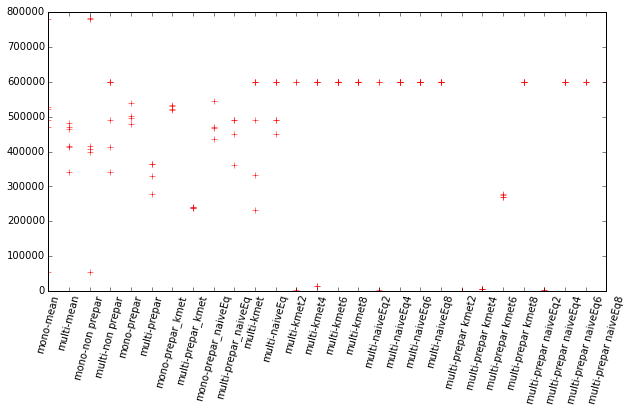

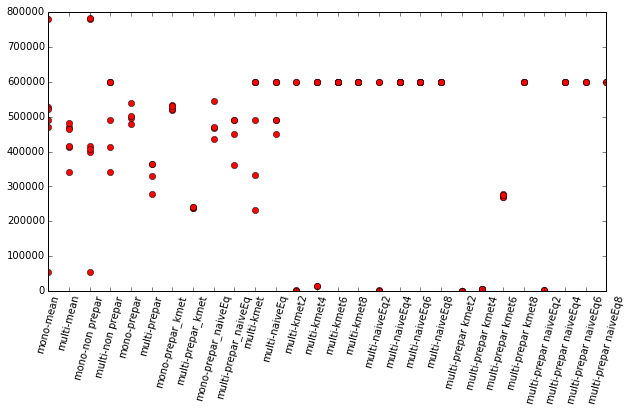

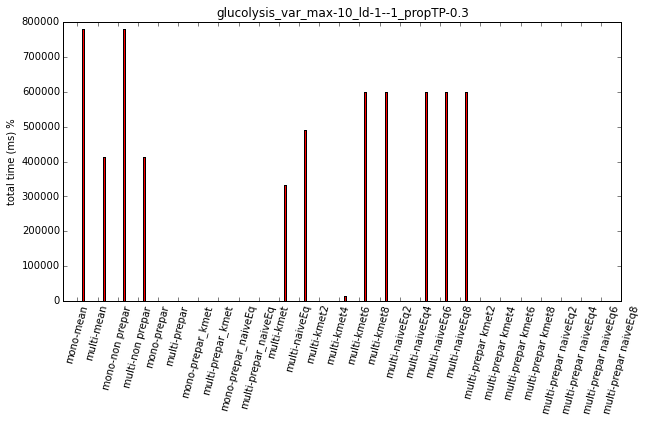

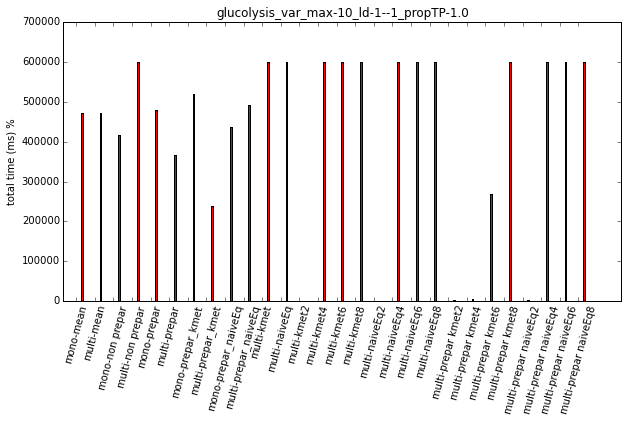

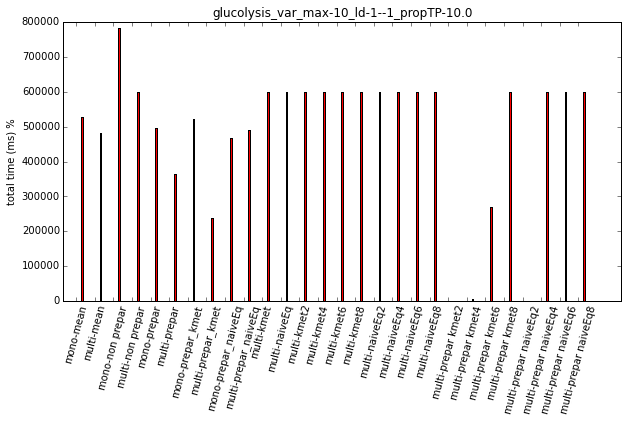

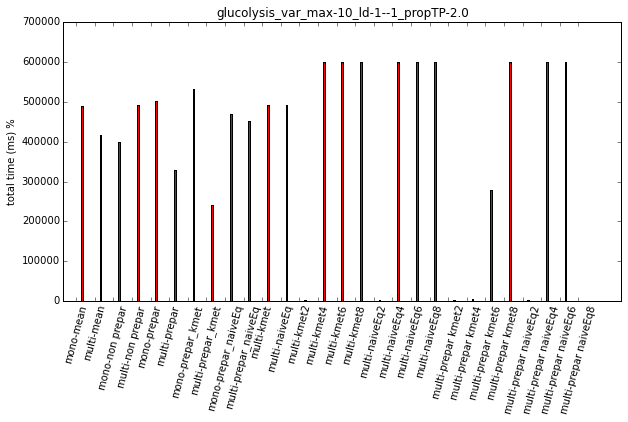

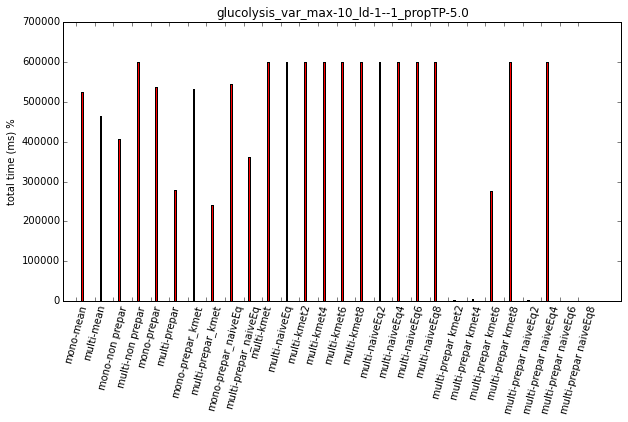

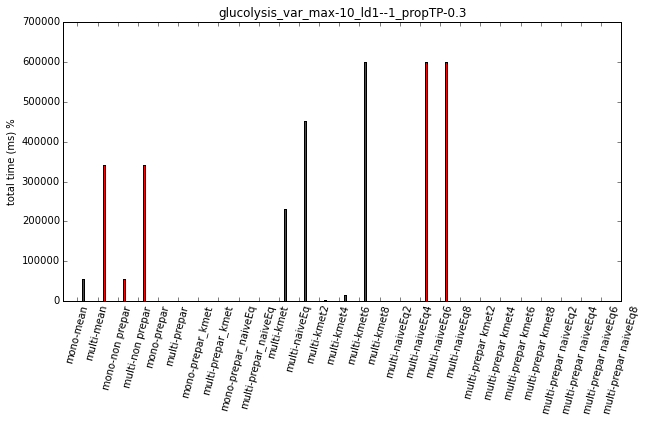

In [42]:
def computeHist(df,ismulti=False):
    hist = []
    #recupere les problems non part
    pb_nonpar = df[df['isprepar']==0]
    pb_par = df[df['isprepar']==1]
    pb_prepar_naiveEq = df[df['prepar']=='naiveEq']
    pb_prepar_kmet = df[df['prepar']=='kmet']

    pb_nonprepar_naiveEq = df[(df['dist'].str.contains('naiveEq'))&(df['isprepar']==0)]
    pb_nonprepar_kmet = df[(df['dist'].str.contains('kmet'))&(df['isprepar']==0)]



    hist.append(df[var].mean())
    hist.append(pb_nonpar[var].mean())
    hist.append(pb_par[var].mean())

    #ceci est absurde pour le mono!!
    hist.append(pb_nonprepar_kmet[var].mean())
    hist.append(pb_nonprepar_naiveEq[var].mean())

    hist.append(pb_prepar_kmet[var].mean())
    hist.append(pb_prepar_naiveEq[var].mean())

    if ismulti:
        par = ['kmet','naiveEq']
        ag = [2,4,6,8]
        for pb_kmet, pb_naiveEq in [(pb_nonprepar_kmet,pb_nonprepar_naiveEq),(pb_prepar_kmet,pb_prepar_naiveEq)]:
            for p in par:
                for a in ag:
                    if p == 'kmet':
                        pb_local = pb_kmet[pb_kmet['numagent']==a]
                    else:
                        pb_local = pb_naiveEq[pb_naiveEq['numagent']==a]
                    hist.append(pb_local[var].mean())
    return hist

import math
def aggregate_mono(df):
    df['indagg_mono'] =  df['pbbase'] + '_var'+df['var'].map(str) + '_propTP-'+df['propTP'].map(str) # +df['dist']



#plotter le tps d'Exec des problems non-prépartitionnés 
#en fonction de propvar, lengthvar, propTP

#et plotter la même chose pour les différentes prépartitions et les différents agents.

#l'idéal étant d'avoir sur une même courbe la référence et les deux variantesdonc d'Avoir 
#4 = [2,4,6,8 agents]
#et 3 dimensions à explorer soit 12 graphiques au total
def makeHistoTotalTime(df, limite, bins=30, title=''):
    df = df['total time']
    s= pd.Series(df, name ='total time')
    tooL = [el for el in s if el > limite]
    a = pd.np.array(s)
    a = a/1000./60.   #convert into minutes
    
    hist, bins = np.histogram(a, bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    
    
    plt.bar(center, hist, align='center', width=width,color = 'r')
    plt.title(title)
    plt.show()
    print 'Il y a ', len(tooL), 'problèmes qui dépassent la limite de ',limite,'ms'
    

#centers = mono, kmet, naiveEq, kmet
#r = dfFin.groupby([['propTP','propvar','lengthvar','dist','prepar', 'methodvar']])

figcum, axcum = plt.subplots(figsize = (10,5))

figcumbis, axcumbis = plt.subplots(figsize = (10,5))
centers = [1,2,3,4,5]#,6,7,8]
aggregate_mono(dfFin)
aggregate_mono(dfMulti)
#aggregate_mono
i = 0
var = 'total time'
width = 0.1
def merge_tuples(l):
    res = []
    for el1,el2 in l :
        res.append(el1)
        res.append(el2)
    return res
for names, group in dfMulti.groupby(['indagg_mono']):
    #(propTP, propvar, lengthvar, dist, prepar,methodvar) = names
    if len(group.index) > 10:
        labels = ['mean','non prepar','prepar','kmet', 'naiveEq', 'prepar_kmet','prepar_naiveEq']
        labelsMulti = ['kmet2','kmet4', 'kmet6', 'kmet8', 'naiveEq2','naiveEq4', 'naiveEq6', 'naiveEq8',\
                  'prepar kmet2','prepar kmet4', 'prepar kmet6', 'prepar kmet8', 'prepar naiveEq2','prepar naiveEq4', 'prepar naiveEq6', 'prepar naiveEq8']
        hist= []
        
        
        
    
            #print hist
        #mono
        monopb = dfFin[dfFin['indagg_mono'] == names]
        
        hist +=computeHist(monopb)
        new_labels = ['mono-'+label for label in labels]
        #multi
        #group
       
        hist +=computeHist(group,ismulti = True)
        new_labels += ['multi-'+label for label in labels]
        new_labels += ['multi-'+label for label in labelsMulti]
        labels = new_labels
        
        
        
        print labels
        d= dict()
        for index,l in enumerate(labels) :
            d[l] = index
        
        
        labels_order_mono = ['mean','non prepar','prepar', 'prepar_kmet','prepar_naiveEq']
      
        labels_merge = [('mono-'+lab,'multi-'+lab) for lab in labels_order_mono]
        labels_merge = merge_tuples(labels_merge)
        print labels_merge
        
        labelsMulti = ['multi-'+label for label in labelsMulti]
        label_order_multi_rest = ['multi-kmet', 'multi-naiveEq'] + labelsMulti
        labels_merge += label_order_multi_rest

        #now get the field corresponding to these values in the hist
        order = [d[label] for label in labels_merge]
        print order
        hist = np.array(hist)
        new_hist = hist[order]
        hist = new_hist
        labels = labels_merge
        
        """
        if len(hist) < len(labels):
            continue
        mustcontinue= False
        for el in hist:
            if math.isnan(el):
                mustcontinue= True
                break
        if mustcontinue :
            continue
        """
        fig, ax = plt.subplots(figsize = (10,5))
        ax.set_ylabel('total time (ms) %')
        ax.set_title(names)
        centers = np.arange(1,len(hist)+1)
        ax.bar(centers, hist, align='center', width=width,color = 'r')
        ax.set_xticks(centers-0.3)#,rot='vertical')
        ax.set_xticklabels(labels[:len(hist)],rotation=75)

        axcum.plot(centers, hist, '+', color = 'r')
        axcum.set_xticks(centers)
        axcum.set_xticklabels(labels[:len(hist)],rotation=75)
        
        axcumbis.plot(centers, hist, 'ro', color = 'r')
        axcumbis.set_xticks(centers)#,rot='vertical')
        axcumbis.set_xticklabels(labels[:len(hist)],rotation=75)
        i+=1
        if i >5:
            break

#by_var['nb Messages'].agg(['mean']).plot(ax=ax,kind = 'bar',width = 0.2,position =0)